<a href="https://colab.research.google.com/github/Yaoc0009/monsterenergy/blob/main/ContourMatching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Upload image
from google.colab import files
uploaded = files.upload()

Saving 2.bmp to 2 (1).bmp
Saving a4.bmp to a4 (1).bmp
Saving C.bmp to C (1).bmp


In [ ]:
def extractCont(im):
  imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(imgray,(5,5),0)
  blur_inv = cv2.bitwise_not(blur)

  ret,binary = cv2.threshold(blur_inv,0,255,cv2.THRESH_OTSU)
  contours, hierarchy = cv2.findContours(binary.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  return contours

In [ ]:
def cont2Complex(contours):
  U = []
  for i in range(len(contours)):
    real = contours[i][0][0]
    imag = 1j*contours[i][0][1]
    U.append(real + imag)

  return U

In [ ]:
def getFD(U, num):
  dft = np.fft.fft(U)
  dft_shift = np.fft.fftshift(dft)
  
  #Translation Invariance - Remove the DC component which locks in the location information
  dft_t = np.delete(dft_shift,len(dft)//2)

  #Rotation Invariance - Multiple by abs for contour points to rotate.
  #Abs gives magnitude of angle of rotation 
  dft_tr = np.abs(dft_t)

  #Scale Invariance 
  dft_trs = list(map(lambda x: x/dft_tr[0],dft_tr))

  #Take lowest positive frequency components for template matching
  index = int(num*len(dft_trs))
  fd = dft_trs[0:index]
  
  return fd
  

In [ ]:
def getFD(U, num):
  dft = np.fft.fft(U)
  
  #Translation Invariance - Remove the DC component which locks in the location information
  dft_t = np.delete(dft,0)

  #Rotation Invariance - Multiple by abs for contour points to rotate.
  #Abs gives magnitude of angle of rotation 
  dft_tr = np.abs(dft_t)

  #Scale Invariance 
  dft_trs = list(map(lambda x: x/dft_tr[0],dft_tr))

  #Take lowest positive frequency components for template matching
  fd = []
  for i in range(int(num*len(dft_trs))):
    fd.append(dft_trs[i])
  return fd
  

In [ ]:
import numpy as np
import cv2

im_C = cv2.imread('C.bmp')
im_2 = cv2.imread('2.bmp')

contours_C = extractCont(im_C)
contours_2 = extractCont(im_2)

U_C = cont2Complex(contours_C[0])
U_2 = cont2Complex(contours_2[0])

fd_C = getFD(U_C,0.3)
fd_2 = getFD(U_2,0.3)

In [ ]:
im0 = cv2.imread('a4.bmp')
contours0 = extractCont(im0)

U_a4 = []
for i in range(len(contours0)):
  U_a4.append(cont2Complex(contours0[i]))

fd = []
for i in range(len(U_a4)):
  fd.append(getFD(U_a4[i], 0.3))

In [ ]:
def matchFD(contour,template,sad_thresh):
  index = []
  for j in range(len(contour)):
    sad = 0
    for i in range(len(template)):
      a = template[i]
      if i < len(contour[j]):
        b = contour[j][i]
      else:
        b = template[i]
      sad += abs(a-b)
   
    if sad < sad_thresh:
      index.append(j)
  return index

In [ ]:
contindex_C = matchFD(fd, fd_C, 0.63)
contindex_2 = matchFD(fd, fd_2, 1.15)
contindex_2 = set(contindex_2) - set(contindex_C)
contindex_2 = list(contindex_2)

contindex_2

[33, 2, 3, 58, 37, 44, 16, 17, 49, 23, 26]

In [ ]:
#Create an array of all the arrays to be plotted, where 1 array represents 1 contours that matched the template. 
#For all contours that matched the templates, it will be plotted
cntC = []
for i in range(len(contindex_C)):
  if cv2.contourArea(contours0[contindex_C[i]]) > 3500:
    cntC.append(contours0[contindex_C[i]])
cnt2 = []
for i in range(len(contindex_2)):
  if cv2.contourArea(contours0[contindex_2[i]]) > 3500:
    cnt2.append(contours0[contindex_2[i]])

In [ ]:
#Approximate contours to polygons + get bounding rects and circles
#For each contour, it will be saved as a polygon so that it will be easier to plot the contours
poly_C = [None]*len(cntC)
boundRect_C = [None]*len(cntC)
for i, c in enumerate(cntC):
  poly_C[i] = cv2.approxPolyDP(c, 3, True)
  boundRect_C[i] = cv2.boundingRect(poly_C[i])

poly_2 = [None]*len(cnt2)
boundRect_2 = [None]*len(cnt2)
for i, c in enumerate(cnt2):
  poly_2[i] = cv2.approxPolyDP(c, 3, True)
  boundRect_2[i] = cv2.boundingRect(poly_2[i])

In [ ]:
#Plot the arrays within the contourz array that contains plotting information for all matched contours
im = cv2.imread('a4.bmp')

for i in range(len(cntC)):
  cv2.drawContours(im, poly_C, i, (0,0,255), 3)
  cv2.rectangle(im, (int(boundRect_C[i][0]), int(boundRect_C[i][1])), (int(boundRect_C[i][0]+boundRect_C[i][2]), int(boundRect_C[i][1]+boundRect_C[i][3])), (0,255,0), 3)

for i in range(len(cnt2)):
  cv2.drawContours(im, poly_2, i, (255,0,), 3)
  cv2.rectangle(im, (int(boundRect_2[i][0]), int(boundRect_2[i][1])), (int(boundRect_2[i][0]+boundRect_2[i][2]), int(boundRect_2[i][1]+boundRect_2[i][3])), (0,255,0), 3)

cv2.imwrite("match.png", im)

True

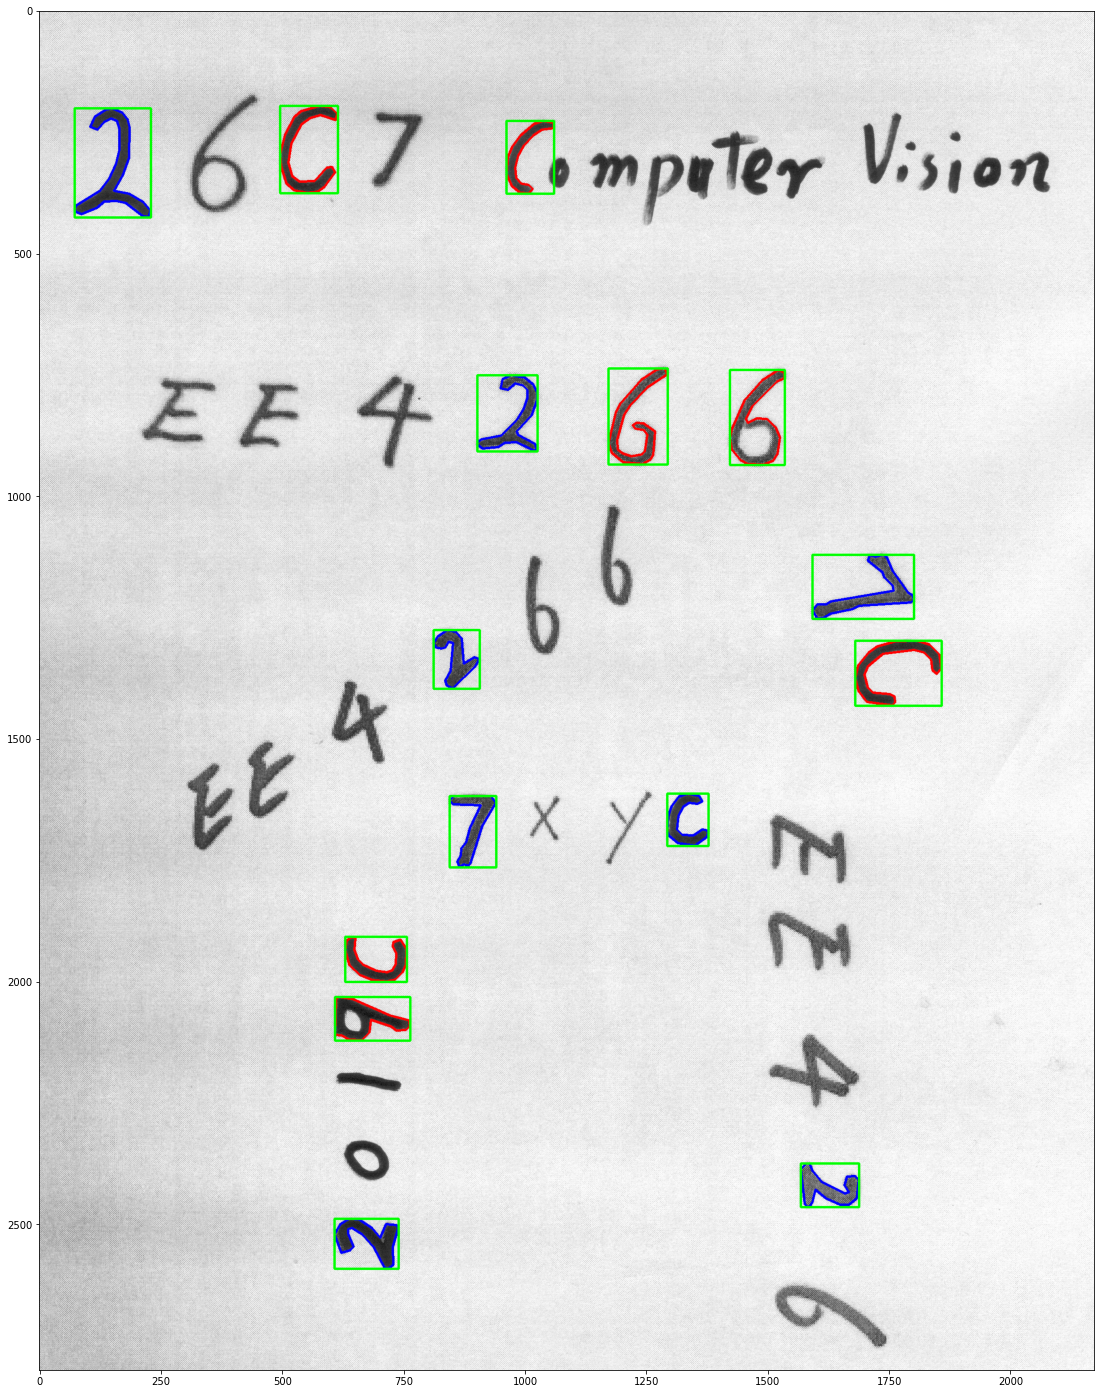

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# read images
img_M = mpimg.imread('match.png')

# display images
fig, ax = plt.subplots()
fig.set_size_inches(40, 25)
ax.imshow(img_M);